###  DeepPCB Dataset - Exploratory Data Analysis (EDA)

 Goal: Understand the structure, size, image format, labels, and class distribution of the DeepPCB dataset before preprocessing and training

In [25]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter

# Set dataset path
DATA_PATH = "../data/DeepPCB/PCBData"

# Check if dataset path exists
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset path not found at: {DATA_PATH}")

print("✅ Dataset path found!")

✅ Dataset path found!


In [26]:
group_dirs = [d for d in os.listdir(DATA_PATH) if d.startswith("group")]
print(f"Total number of PCB sample groups: {len(group_dirs)}")

# Show a few example folder names
group_dirs[:5]

Total number of PCB sample groups: 11


['group00041', 'group12000', 'group12100', 'group12300', 'group13000']

###  Explore the train/test split files (trainval.txt, test.txt)
 These contain the group names used for training and testing.

In [27]:
trainval_path = os.path.join("../data/DeepPCB/PCBData", "trainval.txt")
test_path = os.path.join("../data/DeepPCB/PCBData", "test.txt")

if os.path.exists(trainval_path):
    with open(trainval_path) as f:
        train_list = f.readlines()
    print(f"Train/Val groups: {len(train_list)}")
else:
    print(" trainval.txt not found")

if os.path.exists(test_path):
    with open(test_path) as f:
        test_list = f.readlines()
    print(f"Test groups: {len(test_list)}")
else:
    print(" test.txt not found")

Train/Val groups: 1000
Test groups: 500


#  Check image structure (template vs test)
 open one example group to check file names, shapes, and channels.

In [28]:
sample_group = group_dirs[0]
sample_path = os.path.join(DATA_PATH, sample_group)

# Inner folder (e.g., group00041 → 00041)
inner_folder = os.path.basename(sample_group).replace("group", "")
inner_path = os.path.join(sample_path, inner_folder)

# List files
files = os.listdir(inner_path)
print("Files inside:", files[:5])

# Use 'temp' instead of 'template'
template_path = os.path.join(inner_path, [f for f in files if "temp" in f][0])
test_path = os.path.join(inner_path, [f for f in files if "test" in f][0])

# Read images
template = cv2.imread(template_path)
test = cv2.imread(test_path)

print("Template path:", template_path)
print("Test path:", test_path)
print(f"Template shape: {template.shape}")
print(f"Test shape: {test.shape}")

Files inside: ['00041000_temp.jpg', '00041000_test.jpg', '00041001_temp.jpg', '00041001_test.jpg', '00041002_temp.jpg']
Template path: ../data/DeepPCB/PCBData\group00041\00041\00041000_temp.jpg
Test path: ../data/DeepPCB/PCBData\group00041\00041\00041000_test.jpg
Template shape: (640, 640, 3)
Test shape: (640, 640, 3)


### Visualize Template vs Test Image

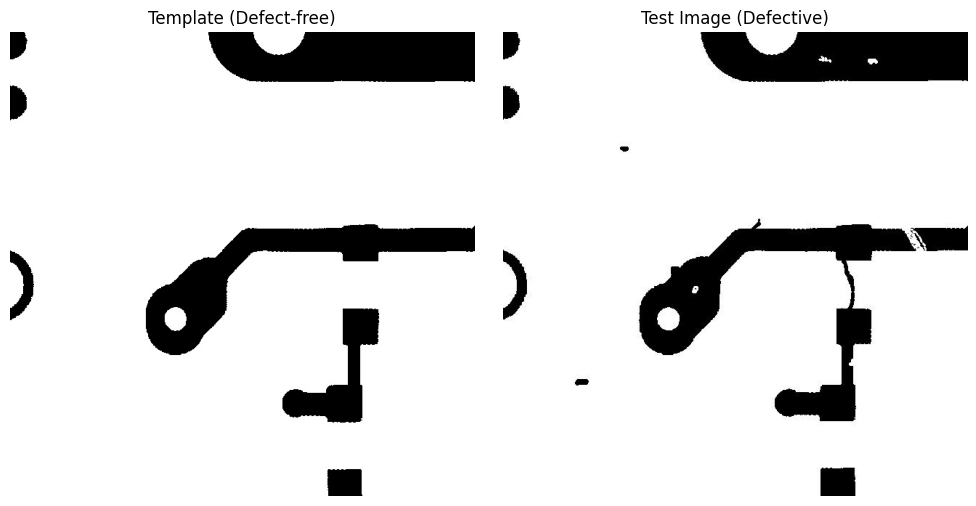

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
ax[0].set_title("Template (Defect-free)")
ax[0].axis("off")

ax[1].imshow(cv2.cvtColor(test, cv2.COLOR_BGR2RGB))
ax[1].set_title("Test Image (Defective)")
ax[1].axis("off")

plt.tight_layout()
plt.show()

### Create and Visualize a Difference Map to highlight deefect

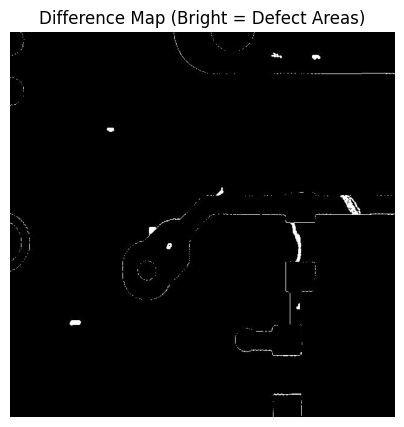

In [30]:
gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
gray_test = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)

# Absolute difference between images
diff = cv2.absdiff(gray_test, gray_template)

plt.figure(figsize=(5, 5))
plt.imshow(diff, cmap='gray')
plt.title("Difference Map (Bright = Defect Areas)")
plt.axis("off")
plt.show()

### image size statistics across the dataset

Checking image sizes: 100%|██████████| 11/11 [00:00<00:00, 42.65it/s]


Average Height: 640.00, Average Width: 640.00


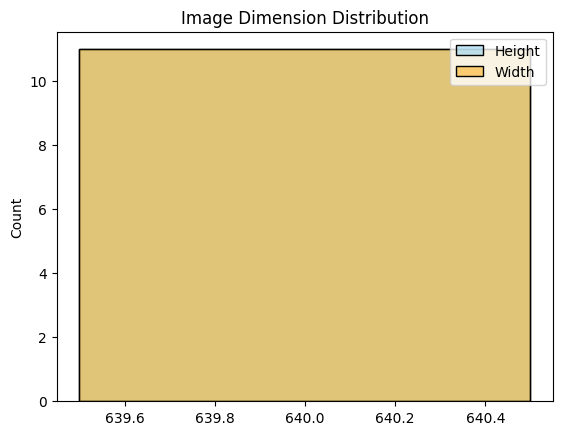

In [31]:
heights, widths = [], []
for group in tqdm(group_dirs[:50], desc="Checking image sizes"):  # limit to first 50 for speed
    inner_folder = os.path.basename(group).replace("group", "")
    inner_path = os.path.join(DATA_PATH, group, inner_folder)
    if not os.path.exists(inner_path):
        continue
    test_files = [f for f in os.listdir(inner_path) if "test" in f]
    if not test_files:
        continue
    test_img = cv2.imread(os.path.join(inner_path, test_files[0]))
    if test_img is not None:
        h, w = test_img.shape[:2]
        heights.append(h)
        widths.append(w)

print(f"Average Height: {np.mean(heights):.2f}, Average Width: {np.mean(widths):.2f}")

sns.histplot(heights, color="skyblue", kde=True, label="Height")
sns.histplot(widths, color="orange", kde=True, label="Width")
plt.legend()
plt.title("Image Dimension Distribution")
plt.show()

### Find corresponding label file inside *_not folder

In [32]:
import os
import pandas as pd
from tqdm import tqdm

DATA_DIR = "../data/DeepPCB/PCBData"

def check_missing_files(dataset_dir=DATA_DIR):
    report = []
    group_dirs = [d for d in os.listdir(dataset_dir) if d.startswith("group")]

    for group in tqdm(group_dirs, desc="Checking groups"):
        group_path = os.path.join(dataset_dir, group)
        subdirs = [d for d in os.listdir(group_path) if os.path.isdir(os.path.join(group_path, d))]

        for sub in subdirs:
            if sub.endswith("_not"):
                continue

            img_dir = os.path.join(group_path, sub)
            label_dir = os.path.join(group_path, f"{sub}_not")

            if not os.path.exists(label_dir):
                print(f"[⚠️] Missing label folder: {label_dir}")
                continue

            # ✅ Loop over ALL test images
            test_files = [f for f in os.listdir(img_dir) if f.endswith("_test.jpg")]
            if not test_files:
                print(f"[⚠️] No _test.jpg found in {img_dir}")
                continue

            for test_file in test_files:
                base_name = test_file.replace("_test.jpg", "")
                temp_path = os.path.join(img_dir, f"{base_name}_temp.jpg")
                test_path = os.path.join(img_dir, test_file)
                label_path = os.path.join(label_dir, f"{base_name}.txt")

                missing = []
                if not os.path.exists(temp_path):
                    missing.append("template")
                if not os.path.exists(test_path):
                    missing.append("test")
                if not os.path.exists(label_path):
                    missing.append("label")

                if missing:
                    report.append({
                        "group": group,
                        "subfolder": sub,
                        "base_name": base_name,
                        "missing": ", ".join(missing)
                    })

    if not report:
        print("\n✅ All template, test, and label files are correctly paired.")
    else:
        print(f"\n⚠️ Found {len(report)} missing or mismatched entries.")
        df = pd.DataFrame(report)
        display(df.head())

    return report


### Count defect classes across multiple groups

Counting defect classes: 100%|██████████| 11/11 [00:11<00:00,  1.06s/it]

 Defect Class Distribution: Counter({'3': 1965, '1': 1942, '4': 1625, '2': 1506, '6': 1501, '5': 1474})



C:\Users\singh\AppData\Local\Temp\ipykernel_1380\2685512436.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(defect_counter.keys()), y=list(defect_counter.values()), palette="mako")


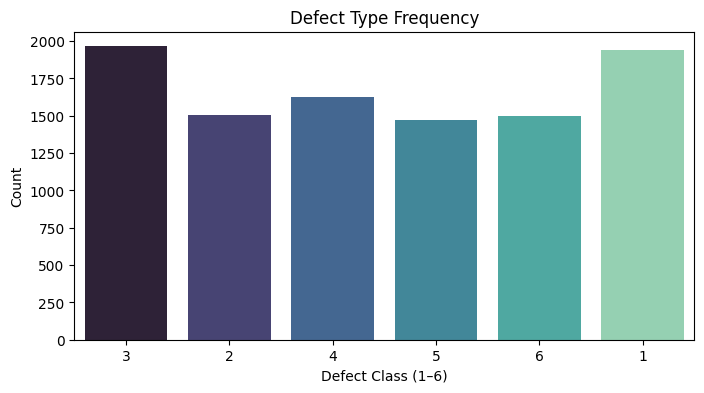

In [33]:
# 📊 Step 8: Count defect classes across dataset (handles *_not structure)

defect_counter = Counter()

for group in tqdm(group_dirs[:100], desc="Counting defect classes"):
    inner_folder = os.path.basename(group).replace("group", "")
    inner_path = os.path.join(DATA_PATH, group, inner_folder)
    label_path = inner_path + "_not"

    if not os.path.exists(inner_path) or not os.path.exists(label_path):
        continue

    label_files = [f for f in os.listdir(label_path) if f.endswith(".txt")]
    for lbl in label_files:
        with open(os.path.join(label_path, lbl)) as f:
            lines = f.readlines()
        for line in lines:
            # Each line: x y w h defect_class
            parts = line.strip().split()
            if len(parts) >= 5:
                defect_class = parts[-1]
                defect_counter[defect_class] += 1

if defect_counter:
    print(" Defect Class Distribution:", defect_counter)
    plt.figure(figsize=(8,4))
    sns.barplot(x=list(defect_counter.keys()), y=list(defect_counter.values()), palette="mako")
    plt.title("Defect Type Frequency")
    plt.xlabel("Defect Class (1–6)")
    plt.ylabel("Count")
    plt.show()
else:
    print(" No label data found in checked groups.")


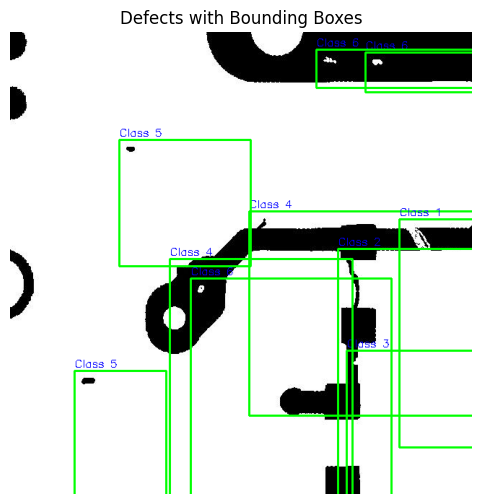

In [34]:
# 🎯 Step 9: Visualize bounding boxes from a label file

test_vis = test.copy()

if os.path.exists(label_path):
    for line in labels:
        parts = line.strip().split()
        if len(parts) >= 5:
            x, y, w, h, cls = map(int, parts[:5])
            cv2.rectangle(test_vis, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(test_vis, f"Class {cls}", (x, y - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
else:
    print("⚠️ No label file found, skipping visualization.")

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(test_vis, cv2.COLOR_BGR2RGB))
plt.title("Defects with Bounding Boxes")
plt.axis("off")
plt.show()


### EDA summary

In [35]:


print(f"Total PCB groups analyzed: {len(group_dirs)}")
print(f"Average Image Size: {int(np.mean(heights))}x{int(np.mean(widths))}")
print(f"Total Defect Classes Found: {len(defect_counter)}")
print("Class Distribution:", defect_counter)


Total PCB groups analyzed: 11
Average Image Size: 640x640
Total Defect Classes Found: 6
Class Distribution: Counter({'3': 1965, '1': 1942, '4': 1625, '2': 1506, '6': 1501, '5': 1474})


In [ ]:
# import os
# import pandas as pd
# from tqdm import tqdm


# DATA_DIR = "../data/DeepPCB/PCBData"

# print(f"Checking dataset directory: {DATA_DIR}")
# if not os.path.exists(DATA_DIR):
#     raise FileNotFoundError(f" Dataset path not found: {DATA_DIR}")
# else:
#     print(" Path found! Contains folders:", os.listdir(DATA_DIR)[:5])


# def check_missing_files(dataset_dir=DATA_DIR):
#     report = []
#     total_samples = 0

#     # Get all group folders like group00041, group00042, ...
#     group_dirs = [d for d in os.listdir(dataset_dir) if d.startswith("group")]
#     print(f"Found {len(group_dirs)} groups under {dataset_dir}\n")

#     for group in tqdm(group_dirs, desc="Checking groups"):
#         group_path = os.path.join(dataset_dir, group)
#         subdirs = [d for d in os.listdir(group_path) if os.path.isdir(os.path.join(group_path, d))]

#         for sub in subdirs:
#             if sub.endswith("_not"):
#                 continue  # skip label folders

#             img_dir = os.path.join(group_path, sub)
#             label_dir = os.path.join(group_path, f"{sub}_not")

#             # Check if label folder exists
#             if not os.path.exists(label_dir):
#                 print(f"[⚠️] Missing label folder: {label_dir}")
#                 continue

#             # Get all test images
#             test_files = [f for f in os.listdir(img_dir) if f.endswith("_test.jpg")]
#             total_samples += len(test_files)

#             for test_file in test_files:
#                 base = test_file.replace("_test.jpg", "")
#                 temp_path = os.path.join(img_dir, f"{base}_temp.jpg")
#                 test_path = os.path.join(img_dir, test_file)
#                 label_path = os.path.join(label_dir, f"{base}.txt")

#                 missing = []
#                 if not os.path.exists(temp_path):
#                     missing.append("template")
#                 if not os.path.exists(test_path):
#                     missing.append("test")
#                 if not os.path.exists(label_path):
#                     missing.append("label")

#                 if missing:
#                     report.append({
#                         "group": group,
#                         "subfolder": sub,
#                         "base_name": base,
#                         "missing": ", ".join(missing)
#                     })

    
#     print(f"🔹 Total samples scanned: {total_samples}")
#     print(f"🔸 Missing or mismatched samples: {len(report)}")

#     if len(report) == 0:
#         print(" All template, test, and label files are correctly paired.")
#     else:
#         df = pd.DataFrame(report)
#         display(df.head(10))
#         df.to_csv("data/missing_files_report.csv", index=False)
#         print(" Detailed report saved to: data/missing_files_report.csv")

#     return report



# missing_report = check_missing_files(DATA_DIR)


Checking dataset directory: ../data/DeepPCB/PCBData
 Path found! Contains folders: ['group00041', 'group12000', 'group12100', 'group12300', 'group13000']
Found 11 groups under ../data/DeepPCB/PCBData



Checking groups: 100%|██████████| 11/11 [00:00<00:00, 32.85it/s]

🔹 Total samples scanned: 1500
🔸 Missing or mismatched samples: 0
✅ All template, test, and label files are correctly paired.


In [4]:
import os

roi_root = "data/processed_rois"
classes = sorted([d for d in os.listdir(roi_root) if d.startswith("class_")])
print("Classes found:", classes)


Classes found: ['class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6']
